Cosmology (compact) SS2020

# Exercise 4

## 3. Analytical v.s. Numerical formulas for the dark-matter halo mass functions


The dark-matter halo mass function given by Press & Schechter 1974 is:
$$f_{PS}(\sigma) = \sqrt{\frac{2}{\pi}} \frac{\delta_c}{\sigma} \exp{(-\frac{\delta_c^2}{2\sigma^2})}$$ with $\delta_c = 1.686$. 

by Sheth & Tormen 1999 is: 
$$f_{ST}(\sigma) = A\sqrt{\frac{2a}{\pi}} \frac{\delta_c}{\sigma} \exp{(-\frac{a\delta_c^2}{2\sigma^2}) [1+(\frac{\sigma^2}{a\delta_c^2})^p]}$$ with $A = 0.322, a = 0.707, p = 0.3$. 

by Tinker et al. 2008 is: $$f_T(\sigma) = A [(\frac{\sigma}{b})^{-a} + 1] \exp{(-\frac{c}{\sigma^2})}$$ 

$$\frac{dn}{dM}(M,z) = f(\sigma) \frac{\rho_m}{M} \frac{d \ln{[\sigma^{-1}(M,z)]}}{dM}$$

$$\sigma^2(M,z) = \frac{1}{2\pi^2} \int_0^{\infty}{k^2 P_{lin}(k, z) \tilde{W}^2(k, M)dk}$$

In [1]:
import astropy.constants as cst
import scipy.integrate as intg
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

h = 0.67
H0 = 100*h # km/s /Mpc
km_Mpc = (u.km/u.Mpc).to(1)
rho_avg = 1e10

def a(z):
    return 1/(1+z)

def E(z, dict):
    return np.sqrt(dict["Omega_r0"]*(1+z)**4+dict["Omega_m0"]*(1+z)**3+(1-dict["Omega_m0"]-dict["Omega_L0"]-dict["Omega_r0"])*(1+z)**2+dict["Omega_L0"])

# Hubble factor
def H(z, dict):
    return H0*E(z,dict)
H_vectorized = np.vectorize(H)

# Density parameters
def Omega_m(z, dict):
    return dict["Omega_m0"]*(1+z)**3/E(z, dict)**2
def rho_m(z, dict):
    rho_crt = ((3*(H(z,dict)*km_Mpc)**2/8/np.pi/cst.G.value)*u.kg/(u.m)**3).to(u.Msun/(u.Mpc)**3)
    return Omega_m(z, dict) * rho_crt.value
def Omega_r(z, dict):
    return dict["Omega_r0"]*(1+z)**4/E(z, dict)**2
def Omega_L(z, dict):
    return dict["Omega_L0"]/E(z, dict)**2
def Omega_K(z, dict):
    Omega_K0 = 1-dict["Omega_m0"]-dict["Omega_L0"]-dict["Omega_r0"]
    return Omega_K0*(1+z)**2/E(z, dict)**2
def Omega_b(z, dict):
    return dict["Omega_b0"]*(1+z)**3/E(z, dict)**2

# Growth Factor
def g(z, dict):
    O_m = Omega_m(z, dict)
    O_L = Omega_L(z, dict)
    return 2.5*O_m/(O_m**(4/7)-O_L+(1+O_m/2)*(1+O_L/70))
def D_growth(z, dict):
    return a(z)*g(z, dict)/g(0, dict)

# linear power spectrum
n_S = 1
def BBKS(k, dict):     # transfer function, see https://www.researchgate.net/publication/1899507_Evolution_of_density_perturbations_in_decaying_vacuum_cosmology
    O_b = dict["Omega_b0"]
    Sigma = dict["Omega_m0"]*h*np.exp(-dict["Omega_b0"] - np.sqrt(2*h)*dict["Omega_b0"]/dict["Omega_m0"])
    q = k/(Sigma * h)
    return (np.log(1+2.34*q)/2.34/q)*(1+3.89*q+(16.1*q)**2+(5.46*q)**3+(6.71*q)**4)**(-0.25)
def A(dict):
    R8 = 8/h   # Mpc
    intgrand = lambda k : (k**2)*(k**n_S)*(BBKS(k, dict)**2)*W_TH(k*R8)
    intgr = intg.quad(intgrand, 0, np.inf)[0]
    return (dict["Sigma8"]**2)*2*(np.pi**2)/intgr
def P(k, z, dict):
    return k**n_S*BBKS(k, dict)**2*D_growth(z, dict)**2*A(dict)
P_vectorized = np.vectorize(P)

# mass variance of the linear density field
def W_G(y):     # Window function, Gaussian; see http://www.astro.yale.edu/vdbosch/astro610_lecture9.pdf
    return np.exp(-(y**2)/2)
def sigma_G(R, z, dict):
    intgrand = lambda k: (k**2)*(W_G(k*R)**2)*(k**n_S)*(BBKS(k, dict)**2)
    res = intg.quad(intgrand, 0, np.inf)[0]
    return 1/(2*np.pi**2) * res * D_growth(z, dict)**2 *A(LCDM)
sigma_G_vectorized = np.vectorize(sigma_G)

def W_TH(y):   # Window function, Top hat
    return 3*(np.sin(y) - y*np.cos(y))/(y**3)
def sigma_TH(M, z, dict):
    R = (M/(4/3 *np.pi * rho_m(z, LCDM)))**(1/3)
    intgrand = lambda k: (W_TH(k*R)**2)*(k**2)*(k**n_S)*(BBKS(k, dict)**2)
    res = intg.quad(intgrand, 0, np.inf)[0]
    return 1/(2*np.pi**2) * res * D_growth(z, dict)**2 *A(LCDM)
sigma_TH_vectorized = np.vectorize(sigma_TH)


# a reference of the variance
# see https://www.slac.stanford.edu/econf/C070730/talks/Wechsler_080207.pdf

In [2]:
LCDM = {"Omega_m0": 0.315, "Sigma8":0.829, "Omega_b0":0.02205*h**(-2), "Omega_L0": 0.685, "Omega_r0": 2.47*10**(-5)*h**(-2)}

from scipy.misc import derivative

def dndM_ST(M, z):
    f_for_d = lambda M1: np.log(1/np.sqrt(sigma_TH(M1, z, LCDM)))
    return f_ST(sigma_TH(M, z, LCDM))*rho_m(z, LCDM)/M*derivative(f_for_d, M, dx=1e2) 
dndM_ST_vectorized = np.vectorize(dndM_ST)
def dndM_PS(M, z):
    f_for_d = lambda M1: np.log(1/np.sqrt(sigma_TH(M1, z, LCDM)))
    return f_PS(sigma_TH(M, z, LCDM))*rho_m(z, LCDM)/M*derivative(f_for_d, M, dx=1e2)
dndM_PS_vectorized = np.vectorize(dndM_PS)
def dndM_T(M, z):
    f_for_d = lambda M1: np.log(1/np.sqrt(sigma_TH(M1, z, LCDM)))
    return f_T(sigma_TH(M, z, LCDM))*rho_m(z, LCDM)/M*derivative(f_for_d, M, dx=1e2)
dndM_T_vectorized = np.vectorize(dndM_T)

# see https://watermark.silverchair.com/mnras0402-0191.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAArcwggKzBgkqhkiG9w0BBwagggKkMIICoAIBADCCApkGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMKbrgtEooUHytyxmqAgEQgIICavRyoxJl4HqxW6fH6jqdVNz-tguCjOtYGYL6HU9uUeXDMVQI15YkUaCRyTMuID54BXrfdLNL2NdzKaCTOOFNCLFK54OUQLyuI40N5ckKuHpUdHeKNeEcN66ush1OGEJsJp68wEJ47krSbKZSao2W0bZLOae11UNmVaPV_woIzwGKe2pYJQoCyLmi2rGzqzhJcm2KG9z2ZaycOvwSrTcLT-4S4u6WGs8dtgxNnAP52oafgBaHvds0Uz9Nzw50v7DDkb7TmPd-naKPyxGFcQsoiSQ2YO_GQeiGWOHwyn6fm9PLIot5pPUH8-c9u73W_kzm9Eq4Fvvvt-8M40mfjbieqUFaiwC8vXvvXUzFoLdsM2NDFMx_LfjKZKEXXOrPLNri3mlQ4j8JndKGq88t8v-0nOMQHSvQrMMw8ZIDJKrSiEAlvwgU_46Wx0kdkSZMVzv9AYBVcwUWFxl1wTcVZoSy_fWn3uG2UNtIuFCIegzG6_AJK3-ygUvvB9_HQbiLv1i2FMvZx8P8lUaf6dGfrzoz2gWvbxJepgflXxBJlq0Q29p6ULL5viXvIOolBx3aT8NzQkGilMAiYuveKjNufL4NYjoqcB8bepgg2A0HKTalVejUbOANVvwug9yBVnl70KnLcjvYrPGvxoMeUPOMKypr930ZCWqb6s_QuQ7nHUFXZQoiXXcacMC2QeQMSwomQSxexNGN3ZfDHcIOtGjpuQ4qvNbh_kwj7e24Y3nIXF6xN2xmMC7ZTkN0I9r4la3qSAHLyQh550-rTYk7yTrZqouR014Kj9oxlnwNMjRcm6qKE8tcXCrbLVs2BH0tuw
def f_T(sigma):
    A = 0.6853
    a = 1.868
    b = 0.3324
    c = 1.2266
    return A*((sigma/b)**(-a) + 1)*np.exp(-c/sigma**2)
f_T_vectorized = np.vectorize(f_T)
def f_ST(sigma):
    delta_c = 1.686
    A = 0.322
    a = 0.707
    p = 0.3
    return A*np.sqrt(2*a/np.pi)*(delta_c/sigma)*np.exp(-a*delta_c**2/2/sigma**2) * (1+(sigma**2/a/delta_c**2)**p)
f_ST_vectorized = np.vectorize(f_ST)
def f_PS(sigma):
    delta_c = 1.686
    return np.sqrt(2/np.pi)*(delta_c/sigma)*np.exp(-delta_c**2/2/sigma**2)
f_PS_vectorized = np.vectorize(f_PS)

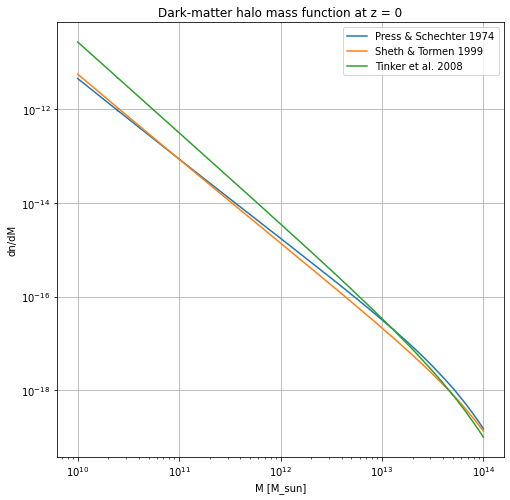

In [10]:
#x = np.linspace(1e10, 1e15, 1000)
x = np.logspace(10, 14, 1000)
y0_PS = dndM_PS_vectorized(x, 0)
y0_ST = dndM_ST_vectorized(x, 0)
y0_T = dndM_T_vectorized(x, 0)
plt.figure(figsize = (8, 8))
plt.plot(x, y0_PS, label = "Press & Schechter 1974")
plt.plot(x, y0_ST, label = "Sheth & Tormen 1999")
plt.plot(x, y0_T, label = "Tinker et al. 2008")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M [M_sun]")
plt.ylabel("dn/dM")
plt.title("Dark-matter halo mass function at z = 0")
plt.legend()
plt.grid()
plt.show()

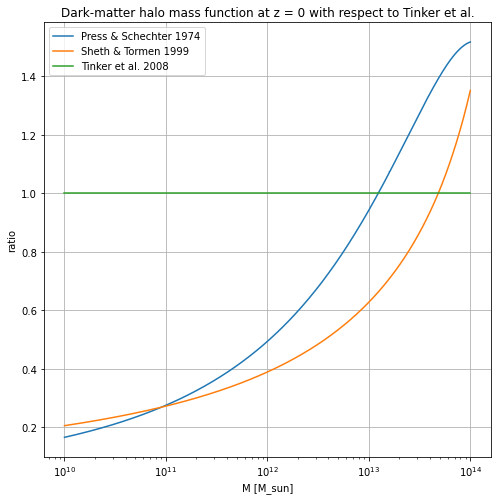

In [11]:
plt.figure(figsize = (8, 8))
plt.plot(x, y0_PS/y0_T, label = "Press & Schechter 1974")
plt.plot(x, y0_ST/y0_T, label = "Sheth & Tormen 1999")
plt.plot(x, y0_T/y0_T, label = "Tinker et al. 2008")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("M [M_sun]")
plt.ylabel("ratio")
plt.title("Dark-matter halo mass function at z = 0 with respect to Tinker et al.")
plt.legend()
plt.grid()
plt.show()

We see that the Sheth & Tormen, as well as the Press & Schechter halo mass function is lower than that of Tinker et al. for mass smaller than several 1e13 solar mass. After that they exceed and continuiously increase to about 40% larger than the halo mass function of Tinker et al. at 1e14 solar mass. 

Now we compare f(sigma) at different redshift.

In [20]:
x = np.logspace(10, 15, 1000)
x0 = sigma_TH_vectorized(x, 0, LCDM)
x1 = sigma_TH_vectorized(x, 1, LCDM)
x4 = sigma_TH_vectorized(x, 4, LCDM)
y_PS0 = f_PS_vectorized(x0)
y_PS1 = f_PS_vectorized(x1)
y_PS4 = f_PS_vectorized(x4)

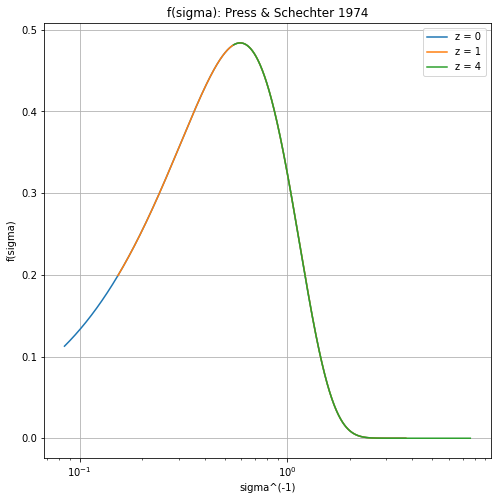

In [25]:
plt.figure(figsize = (8, 8))
plt.plot((x0**(-1)), (y_PS0), label = "z = 0")
plt.plot((x1**(-1)), (y_PS1), label = "z = 1")
plt.plot((x4**(-1)), (y_PS4), label = "z = 4")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("sigma^(-1)")
plt.ylabel("f(sigma)")
plt.title("f(sigma): Press & Schechter 1974")
plt.legend()
plt.grid()
plt.show()

From above plot we see that 3 curves overlaps with each other (the ranges of sigma are slightly different though), so that we could draw the conclusion that the mass function expressed in terms of the mass variance does not depend on redshift. 